In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !unzip /content/drive/MyDrive/cat_siamese_data/train.zip -d /content/drive/MyDrive/cat_siamese_data/train
# !unzip /content/drive/MyDrive/cat_siamese_data/val.zip -d /content/drive/MyDrive/cat_siamese_data/val

In [ ]:
%matplotlib inline
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torchvision.utils
from torchvision.models import mobilenet_v2
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(22222)
if device == 'cuda':
    torch.cuda.manual_seed_all(22222)

print(device)

cuda


In [ ]:
TRAINING_DIR = "/content/drive/MyDrive/cat_siamese_data/train/train"
VALIDATION_DIR = "/content/drive/MyDrive/cat_siamese_data/val/val"
BATCH_SIZE = 16
VAL_BATCH_SIZE = 4
EPOCH = 100

In [ ]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [ ]:
folder_dataset = datasets.ImageFolder(root = TRAINING_DIR)
val_folder_dataset = datasets.ImageFolder(root = VALIDATION_DIR)

In [ ]:
model = mobilenet_v2(pretrained = True)
model.classifier = nn.Sequential(
    nn.Dropout(p = 0.2, inplace = False),
    nn.Linear(in_features = 1280, out_features = 128, bias = True)
)

In [ ]:
len(folder_dataset.imgs)

6650

In [ ]:
class SiameseNetworkDataset(Dataset):
    def __init__(self, imageFolderDataset, transform):
        self.imageFolderDataset = imageFolderDataset
        self.transform = transform
    
    def __getitem__(self, index):
        anchor_tuple = self.imageFolderDataset.imgs[index]
        while True:
            positive_tuple = random.choice(self.imageFolderDataset.imgs)
            if positive_tuple[1] == anchor_tuple[1] and positive_tuple[0] != anchor_tuple[0]:  # anchor와 label이 같고 파일 이름은 다르면
                break
        while True:
            negative_tuple = random.choice(self.imageFolderDataset.imgs)
            if negative_tuple[1] != anchor_tuple[1]:  # anchor와 label이 같지 않으면
                break

        anchor = Image.open(anchor_tuple[0]).convert("RGB")
        positive = Image.open(positive_tuple[0]).convert("RGB")
        negative = Image.open(negative_tuple[0]).convert("RGB")

        anchor = self.transform(anchor)
        positive = self.transform(positive)
        negative = self.transform(negative)
        
        return anchor, positive, negative
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [ ]:
siamese_dataset = SiameseNetworkDataset(
    folder_dataset,
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
)

validation_dataset = SiameseNetworkDataset(
    val_folder_dataset,
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
)

In [ ]:
print(len(siamese_dataset))
print(len(validation_dataset))

6650
703


In [ ]:
train_dataloader = DataLoader(
    siamese_dataset,
    shuffle = True,
    num_workers = 4,
    batch_size = BATCH_SIZE
)

validation_dataloader = DataLoader(
    validation_dataset,
    shuffle = False,
    num_workers = 4,
    batch_size = VAL_BATCH_SIZE
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
net = model.to(device)
criterion = nn.TripletMarginLoss(margin = 1.0, p = 2)
optimizer = optim.Adam(net.parameters(), lr = 0.0005)

scheduler = CosineAnnealingLR(optimizer, T_max=50)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Training - Epoch : 1 (99 / 416)
 loss : 28.633498907089233
Training - Epoch : 1 (199 / 416)
 loss : 44.311596125364304
Training - Epoch : 1 (299 / 416)
 loss : 39.17913410067558
Training - Epoch : 1 (399 / 416)
 loss : 29.478128165006638
Validation - Epoch : 1 loss : 56.43221789598465
Training - Epoch : 2 (99 / 416)
 loss : 28.576714038848877
Training - Epoch : 2 (199 / 416)
 loss : 28.003403142094612
Training - Epoch : 2 (299 / 416)
 loss : 29.716037467122078
Training - Epoch : 2 (399 / 416)
 loss : 21.256914988160133
Validation - Epoch : 2 loss : 39.0912903547287
Training - Epoch : 3 (99 / 416)
 loss : 25.488016039133072
Training - Epoch : 3 (199 / 416)
 loss : 28.22986689209938
Training - Epoch : 3 (299 / 416)
 loss : 24.218639001250267
Training - Epoch : 3 (399 / 416)
 loss : 21.39081436395645
Validation - Epoch : 3 loss : 45.60492983460426
Training - Epoch : 4 (99 / 416)
 loss : 22.279131665825844
Training - Epoch : 4 (199 / 416)
 loss : 19.214747443795204
Training - Epoch : 4 (29

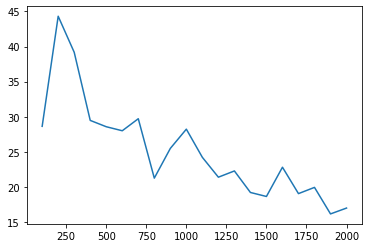

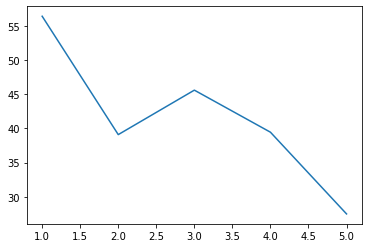

Training - Epoch : 6 (99 / 416)
 loss : 21.919078931212425
Training - Epoch : 6 (199 / 416)
 loss : 18.7042937874794
Training - Epoch : 6 (299 / 416)
 loss : 20.184855073690414
Training - Epoch : 6 (399 / 416)
 loss : 17.328545480966568
Validation - Epoch : 6 loss : 34.737443804740906
Training - Epoch : 7 (99 / 416)
 loss : 17.183358803391457
Training - Epoch : 7 (199 / 416)
 loss : 17.147249653935432
Training - Epoch : 7 (299 / 416)
 loss : 14.713296875357628
Training - Epoch : 7 (399 / 416)
 loss : 18.892215132713318
Validation - Epoch : 7 loss : 39.94032323360443
Training - Epoch : 8 (99 / 416)
 loss : 18.27276560664177
Training - Epoch : 8 (199 / 416)
 loss : 15.187040612101555
Training - Epoch : 8 (299 / 416)
 loss : 14.684358105063438
Training - Epoch : 8 (399 / 416)
 loss : 18.759001448750496
Validation - Epoch : 8 loss : 46.004887878894806
Training - Epoch : 9 (99 / 416)
 loss : 22.195857241749763
Training - Epoch : 9 (199 / 416)
 loss : 17.798418328166008
Training - Epoch : 9 

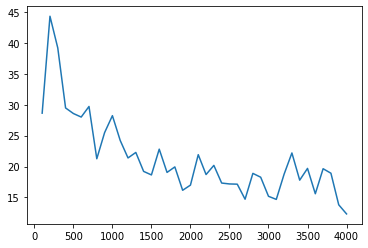

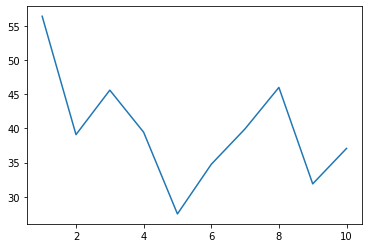

Training - Epoch : 11 (99 / 416)
 loss : 15.78641201555729
Training - Epoch : 11 (199 / 416)
 loss : 14.039779722690582
Training - Epoch : 11 (299 / 416)
 loss : 17.61593559384346
Training - Epoch : 11 (399 / 416)
 loss : 17.27310675382614
Validation - Epoch : 11 loss : 28.31403449177742
Training - Epoch : 12 (99 / 416)
 loss : 18.988825246691704
Training - Epoch : 12 (199 / 416)
 loss : 14.393280684947968
Training - Epoch : 12 (299 / 416)
 loss : 14.342823043465614
Training - Epoch : 12 (399 / 416)
 loss : 14.185524642467499
Validation - Epoch : 12 loss : 31.323317289352417
Training - Epoch : 13 (99 / 416)
 loss : 13.10816676914692
Training - Epoch : 13 (199 / 416)
 loss : 13.404818430542946
Training - Epoch : 13 (299 / 416)
 loss : 15.714217588305473
Training - Epoch : 13 (399 / 416)
 loss : 14.537479519844055
Validation - Epoch : 13 loss : 37.64536488056183
Training - Epoch : 14 (99 / 416)
 loss : 16.634519904851913
Training - Epoch : 14 (199 / 416)
 loss : 13.842732205986977
Traini

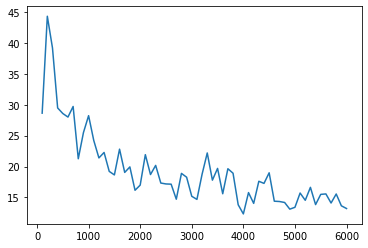

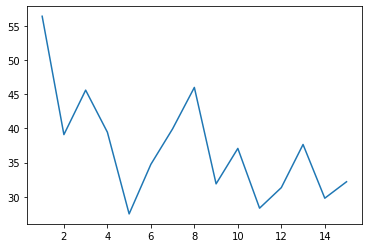

Training - Epoch : 16 (99 / 416)
 loss : 13.426333084702492
Training - Epoch : 16 (199 / 416)
 loss : 12.071966990828514
Training - Epoch : 16 (299 / 416)
 loss : 11.98802725970745
Training - Epoch : 16 (399 / 416)
 loss : 12.005806356668472
Validation - Epoch : 16 loss : 34.711888521909714
Training - Epoch : 17 (99 / 416)
 loss : 13.198871374130249
Training - Epoch : 17 (199 / 416)
 loss : 12.954194366931915
Training - Epoch : 17 (299 / 416)
 loss : 14.671022057533264
Training - Epoch : 17 (399 / 416)
 loss : 12.37752152979374
Validation - Epoch : 17 loss : 25.822546660900116
Training - Epoch : 18 (99 / 416)
 loss : 12.812634691596031
Training - Epoch : 18 (199 / 416)
 loss : 11.967139214277267
Training - Epoch : 18 (299 / 416)
 loss : 10.414952665567398
Training - Epoch : 18 (399 / 416)
 loss : 12.5680330991745
Validation - Epoch : 18 loss : 19.5199576318264
Training - Epoch : 19 (99 / 416)
 loss : 14.177202314138412
Training - Epoch : 19 (199 / 416)
 loss : 11.450588926672935
Traini

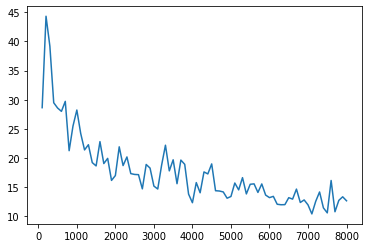

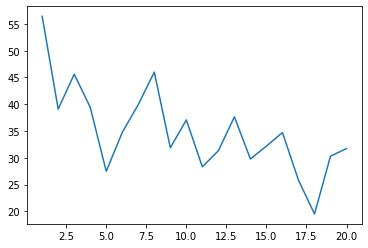

Training - Epoch : 21 (99 / 416)
 loss : 12.300791576504707
Training - Epoch : 21 (199 / 416)
 loss : 15.048843249678612
Training - Epoch : 21 (299 / 416)
 loss : 11.337353706359863
Training - Epoch : 21 (399 / 416)
 loss : 11.582901760935783
Validation - Epoch : 21 loss : 34.317184031009674
Training - Epoch : 22 (99 / 416)
 loss : 11.771202072501183
Training - Epoch : 22 (199 / 416)
 loss : 11.707189410924911
Training - Epoch : 22 (299 / 416)
 loss : 10.203404933214188
Training - Epoch : 22 (399 / 416)
 loss : 7.701227471232414
Validation - Epoch : 22 loss : 30.538738399744034
Training - Epoch : 23 (99 / 416)
 loss : 8.298607110977173
Training - Epoch : 23 (199 / 416)
 loss : 11.9645866304636
Training - Epoch : 23 (299 / 416)
 loss : 8.517942026257515
Training - Epoch : 23 (399 / 416)
 loss : 10.711949467658997
Validation - Epoch : 23 loss : 36.45291429758072
Training - Epoch : 24 (99 / 416)
 loss : 9.150828570127487
Training - Epoch : 24 (199 / 416)
 loss : 15.972519502043724
Trainin

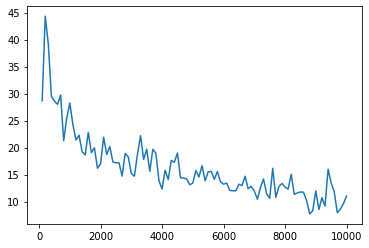

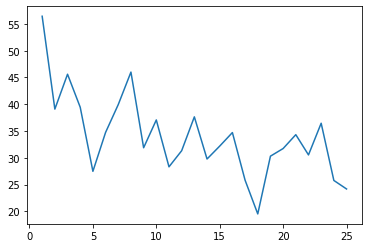

Training - Epoch : 26 (99 / 416)
 loss : 8.7368723154068
Training - Epoch : 26 (199 / 416)
 loss : 11.308737799525261
Training - Epoch : 26 (299 / 416)
 loss : 9.434593424201012
Training - Epoch : 26 (399 / 416)
 loss : 5.857796683907509
Validation - Epoch : 26 loss : 40.41814172267914
Training - Epoch : 27 (99 / 416)
 loss : 13.764393165707588
Training - Epoch : 27 (199 / 416)
 loss : 11.127177074551582
Training - Epoch : 27 (299 / 416)
 loss : 12.33868969976902
Training - Epoch : 27 (399 / 416)
 loss : 8.586657509207726
Validation - Epoch : 27 loss : 35.72229814529419
Training - Epoch : 28 (99 / 416)
 loss : 11.735225051641464
Training - Epoch : 28 (199 / 416)
 loss : 13.405083373188972
Training - Epoch : 28 (299 / 416)
 loss : 11.889352440834045
Training - Epoch : 28 (399 / 416)
 loss : 10.62007261812687
Validation - Epoch : 28 loss : 33.7704815864563
Training - Epoch : 29 (99 / 416)
 loss : 9.23428988456726
Training - Epoch : 29 (199 / 416)
 loss : 9.670446768403053
Training - Epoc

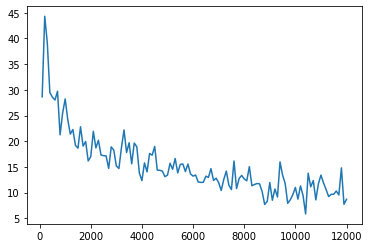

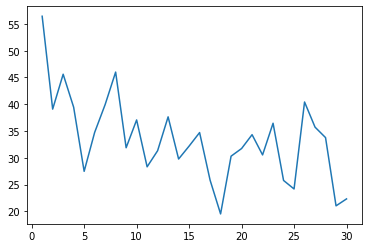

Training - Epoch : 31 (99 / 416)
 loss : 8.561772570014
Training - Epoch : 31 (199 / 416)
 loss : 9.676292940974236
Training - Epoch : 31 (299 / 416)
 loss : 10.852728486061096
Training - Epoch : 31 (399 / 416)
 loss : 9.607600912451744
Validation - Epoch : 31 loss : 20.203621804714203
Training - Epoch : 32 (99 / 416)
 loss : 5.9684866815805435
Training - Epoch : 32 (199 / 416)
 loss : 8.6236692070961
Training - Epoch : 32 (299 / 416)
 loss : 7.659138053655624
Training - Epoch : 32 (399 / 416)
 loss : 9.534972414374352
Validation - Epoch : 32 loss : 21.578089267015457
Training - Epoch : 33 (99 / 416)
 loss : 7.011276498436928
Training - Epoch : 33 (199 / 416)
 loss : 8.547143414616585
Training - Epoch : 33 (299 / 416)
 loss : 7.366584554314613
Training - Epoch : 33 (399 / 416)
 loss : 7.140038043260574
Validation - Epoch : 33 loss : 25.424254298210144
Training - Epoch : 34 (99 / 416)
 loss : 11.857462659478188
Training - Epoch : 34 (199 / 416)
 loss : 10.302831009030342
Training - Epoc

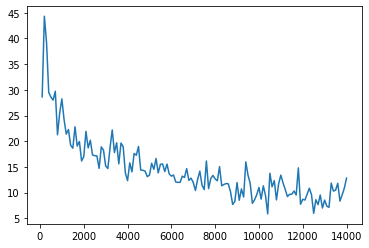

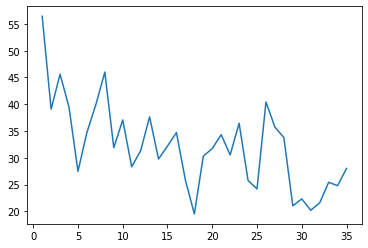

Training - Epoch : 36 (99 / 416)
 loss : 6.920633792877197
Training - Epoch : 36 (199 / 416)
 loss : 9.876300796866417
Training - Epoch : 36 (299 / 416)
 loss : 13.746089860796928
Training - Epoch : 36 (399 / 416)
 loss : 9.379601284861565
Validation - Epoch : 36 loss : 32.33905205130577
Training - Epoch : 37 (99 / 416)
 loss : 7.317048743367195
Training - Epoch : 37 (199 / 416)
 loss : 6.438016787171364
Training - Epoch : 37 (299 / 416)
 loss : 6.4779826402664185
Training - Epoch : 37 (399 / 416)
 loss : 9.910857245326042
Validation - Epoch : 37 loss : 24.983903884887695
Training - Epoch : 38 (99 / 416)
 loss : 8.435366109013557
Training - Epoch : 38 (199 / 416)
 loss : 6.742776304483414
Training - Epoch : 38 (299 / 416)
 loss : 9.76821406185627
Training - Epoch : 38 (399 / 416)
 loss : 9.40397784113884
Validation - Epoch : 38 loss : 26.822682082653046
Training - Epoch : 39 (99 / 416)
 loss : 5.676869034767151
Training - Epoch : 39 (199 / 416)
 loss : 7.311943918466568
Training - Epoc

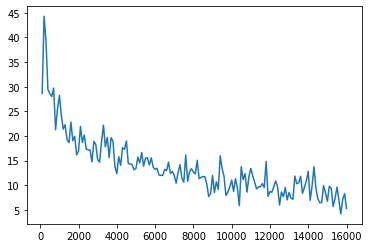

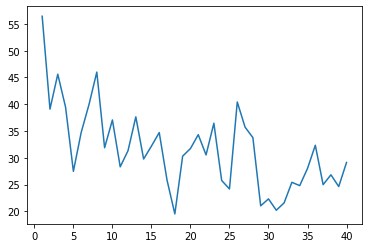

Training - Epoch : 41 (99 / 416)
 loss : 6.477832123637199
Training - Epoch : 41 (199 / 416)
 loss : 5.845590576529503
Training - Epoch : 41 (299 / 416)
 loss : 6.080983981490135
Training - Epoch : 41 (399 / 416)
 loss : 5.035294741392136
Validation - Epoch : 41 loss : 22.08524376153946
Training - Epoch : 42 (99 / 416)
 loss : 6.385989561676979
Training - Epoch : 42 (199 / 416)
 loss : 8.831530123949051
Training - Epoch : 42 (299 / 416)
 loss : 8.440980300307274
Training - Epoch : 42 (399 / 416)
 loss : 6.078502178192139
Validation - Epoch : 42 loss : 29.772369235754013
Training - Epoch : 43 (99 / 416)
 loss : 5.869101852178574
Training - Epoch : 43 (199 / 416)
 loss : 6.328716054558754
Training - Epoch : 43 (299 / 416)
 loss : 5.686399385333061
Training - Epoch : 43 (399 / 416)
 loss : 6.752542778849602
Validation - Epoch : 43 loss : 24.428298592567444
Training - Epoch : 44 (99 / 416)
 loss : 7.616572663187981
Training - Epoch : 44 (199 / 416)
 loss : 7.605358645319939
Training - Epoc

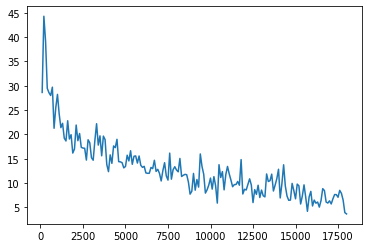

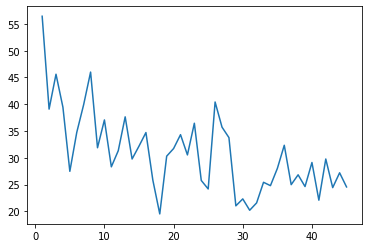

Training - Epoch : 46 (99 / 416)
 loss : 7.91705946624279
Training - Epoch : 46 (199 / 416)
 loss : 4.068670809268951
Training - Epoch : 46 (299 / 416)
 loss : 5.061012431979179
Training - Epoch : 46 (399 / 416)
 loss : 4.444157645106316
Validation - Epoch : 46 loss : 20.14390742778778
Training - Epoch : 47 (99 / 416)
 loss : 7.311042234301567
Training - Epoch : 47 (199 / 416)
 loss : 3.8665492832660675
Training - Epoch : 47 (299 / 416)
 loss : 5.304091289639473
Training - Epoch : 47 (399 / 416)
 loss : 5.222879245877266
Validation - Epoch : 47 loss : 36.57892608642578
Training - Epoch : 48 (99 / 416)
 loss : 9.325249895453453
Training - Epoch : 48 (199 / 416)
 loss : 6.29739548265934
Training - Epoch : 48 (299 / 416)
 loss : 5.98152694106102
Training - Epoch : 48 (399 / 416)
 loss : 6.106525927782059
Validation - Epoch : 48 loss : 24.38703042268753
Training - Epoch : 49 (99 / 416)
 loss : 4.065314620733261
Training - Epoch : 49 (199 / 416)
 loss : 3.619002491235733
Training - Epoch : 

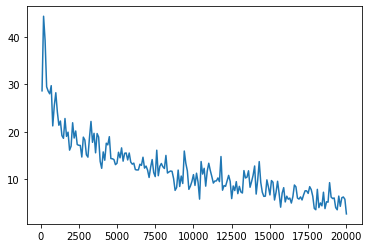

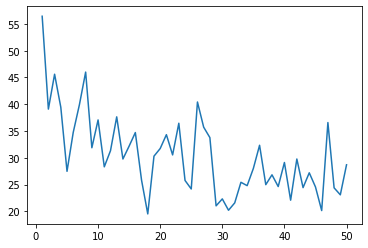

Training - Epoch : 51 (99 / 416)
 loss : 8.856519043445587
Training - Epoch : 51 (199 / 416)
 loss : 5.27878575026989
Training - Epoch : 51 (299 / 416)
 loss : 8.859939247369766
Training - Epoch : 51 (399 / 416)
 loss : 7.313569128513336
Validation - Epoch : 51 loss : 27.322092175483704
Training - Epoch : 52 (99 / 416)
 loss : 6.129784911870956
Training - Epoch : 52 (199 / 416)
 loss : 8.394335761666298
Training - Epoch : 52 (299 / 416)
 loss : 4.217272311449051
Training - Epoch : 52 (399 / 416)
 loss : 8.617416635155678
Validation - Epoch : 52 loss : 32.930694192647934
Training - Epoch : 53 (99 / 416)
 loss : 8.512388691306114
Training - Epoch : 53 (199 / 416)
 loss : 7.024410039186478
Training - Epoch : 53 (299 / 416)
 loss : 4.945680215954781
Training - Epoch : 53 (399 / 416)
 loss : 3.9577644765377045
Validation - Epoch : 53 loss : 39.49622303247452
Training - Epoch : 54 (99 / 416)
 loss : 6.612136080861092
Training - Epoch : 54 (199 / 416)
 loss : 3.945435956120491
Training - Epoc

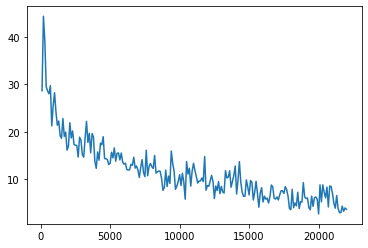

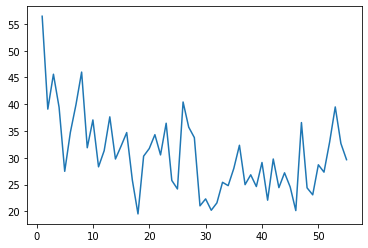

Training - Epoch : 56 (99 / 416)
 loss : 3.4822061508893967
Training - Epoch : 56 (199 / 416)
 loss : 3.413551464676857
Training - Epoch : 56 (299 / 416)
 loss : 10.1357953697443
Training - Epoch : 56 (399 / 416)
 loss : 6.285859510302544
Validation - Epoch : 56 loss : 23.634254425764084
Training - Epoch : 57 (99 / 416)
 loss : 5.968084380030632
Training - Epoch : 57 (199 / 416)
 loss : 7.513236939907074
Training - Epoch : 57 (299 / 416)
 loss : 3.601568043231964
Training - Epoch : 57 (399 / 416)
 loss : 5.663043946027756
Validation - Epoch : 57 loss : 34.1850391626358
Training - Epoch : 58 (99 / 416)
 loss : 6.484614655375481
Training - Epoch : 58 (199 / 416)
 loss : 5.888664558529854
Training - Epoch : 58 (299 / 416)
 loss : 3.464330941438675
Training - Epoch : 58 (399 / 416)
 loss : 2.901014134287834
Validation - Epoch : 58 loss : 23.00965040922165
Training - Epoch : 59 (99 / 416)
 loss : 3.521950513124466
Training - Epoch : 59 (199 / 416)
 loss : 5.637462556362152
Training - Epoch 

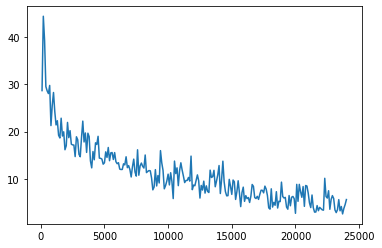

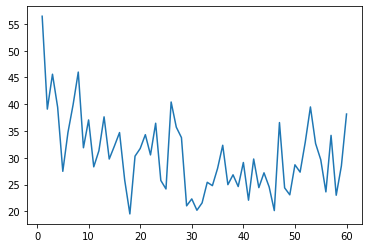

Training - Epoch : 61 (99 / 416)
 loss : 9.575903743505478
Training - Epoch : 61 (199 / 416)
 loss : 4.430917710065842
Training - Epoch : 61 (299 / 416)
 loss : 5.861218139529228
Training - Epoch : 61 (399 / 416)
 loss : 5.433448135852814
Validation - Epoch : 61 loss : 34.241850942373276
Training - Epoch : 62 (99 / 416)
 loss : 2.9324526637792587
Training - Epoch : 62 (199 / 416)
 loss : 3.2210443168878555
Training - Epoch : 62 (299 / 416)
 loss : 5.076519384980202
Training - Epoch : 62 (399 / 416)
 loss : 9.103477284312248
Validation - Epoch : 62 loss : 31.314585626125336
Training - Epoch : 63 (99 / 416)
 loss : 3.17340524494648
Training - Epoch : 63 (199 / 416)
 loss : 4.93928736448288
Training - Epoch : 63 (299 / 416)
 loss : 6.428932100534439
Training - Epoch : 63 (399 / 416)
 loss : 4.169317811727524
Validation - Epoch : 63 loss : 24.84167456626892
Training - Epoch : 64 (99 / 416)
 loss : 4.186938852071762
Training - Epoch : 64 (199 / 416)
 loss : 3.2939995378255844
Training - Epo

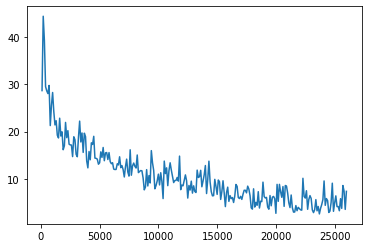

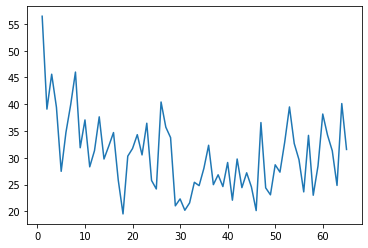

Training - Epoch : 66 (99 / 416)
 loss : 6.589616194367409
Training - Epoch : 66 (199 / 416)
 loss : 4.9708850383758545
Training - Epoch : 66 (299 / 416)
 loss : 4.126950651407242
Training - Epoch : 66 (399 / 416)
 loss : 6.588582262396812
Validation - Epoch : 66 loss : 30.138632118701935
Training - Epoch : 67 (99 / 416)
 loss : 5.688845112919807
Training - Epoch : 67 (199 / 416)
 loss : 5.314781457185745
Training - Epoch : 67 (299 / 416)
 loss : 5.029503524303436
Training - Epoch : 67 (399 / 416)
 loss : 4.397187426686287
Validation - Epoch : 67 loss : 26.837685525417328
Training - Epoch : 68 (99 / 416)
 loss : 2.5317222326993942
Training - Epoch : 68 (199 / 416)
 loss : 3.495300054550171
Training - Epoch : 68 (299 / 416)
 loss : 4.607805967330933
Training - Epoch : 68 (399 / 416)
 loss : 5.268699735403061
Validation - Epoch : 68 loss : 28.33040076494217
Training - Epoch : 69 (99 / 416)
 loss : 2.344014674425125
Training - Epoch : 69 (199 / 416)
 loss : 5.464540362358093
Training - Ep

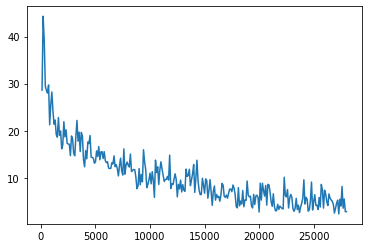

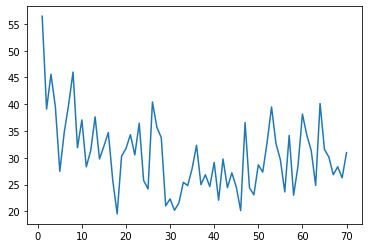

Training - Epoch : 71 (99 / 416)
 loss : 5.407593354582787
Training - Epoch : 71 (199 / 416)
 loss : 4.829715937376022
Training - Epoch : 71 (299 / 416)
 loss : 4.904962778091431
Training - Epoch : 71 (399 / 416)
 loss : 3.375157803297043
Validation - Epoch : 71 loss : 37.131819278001785
Training - Epoch : 72 (99 / 416)
 loss : 3.986505925655365
Training - Epoch : 72 (199 / 416)
 loss : 5.1742834597826
Training - Epoch : 72 (299 / 416)
 loss : 3.482312932610512
Training - Epoch : 72 (399 / 416)
 loss : 4.468239054083824
Validation - Epoch : 72 loss : 32.788454443216324
Training - Epoch : 73 (99 / 416)
 loss : 3.832391932606697
Training - Epoch : 73 (199 / 416)
 loss : 5.642366990447044
Training - Epoch : 73 (299 / 416)
 loss : 3.3367190212011337
Training - Epoch : 73 (399 / 416)
 loss : 2.932083785533905
Validation - Epoch : 73 loss : 35.59321531653404
Training - Epoch : 74 (99 / 416)
 loss : 6.936107710003853
Training - Epoch : 74 (199 / 416)
 loss : 4.614969149231911
Training - Epoch

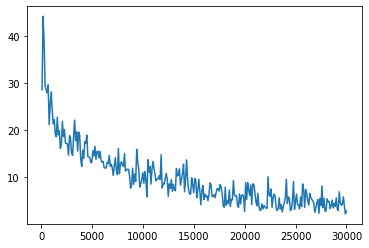

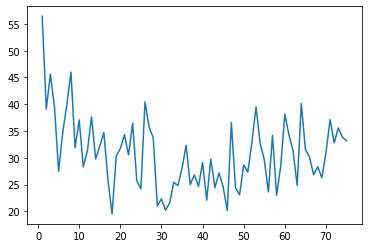

Training - Epoch : 76 (99 / 416)
 loss : 3.789659470319748
Training - Epoch : 76 (199 / 416)
 loss : 4.176192939281464
Training - Epoch : 76 (299 / 416)
 loss : 4.224197208881378
Training - Epoch : 76 (399 / 416)
 loss : 7.53577147424221
Validation - Epoch : 76 loss : 42.71741333603859
Training - Epoch : 77 (99 / 416)
 loss : 6.082908183336258
Training - Epoch : 77 (199 / 416)
 loss : 6.67644090950489
Training - Epoch : 77 (299 / 416)
 loss : 7.532568424940109
Training - Epoch : 77 (399 / 416)
 loss : 5.626507386565208
Validation - Epoch : 77 loss : 38.680468916893005
Training - Epoch : 78 (99 / 416)
 loss : 6.60994279384613
Training - Epoch : 78 (199 / 416)
 loss : 2.8569009453058243
Training - Epoch : 78 (299 / 416)
 loss : 3.795977383852005
Training - Epoch : 78 (399 / 416)
 loss : 4.20231856405735
Validation - Epoch : 78 loss : 35.113967061042786
Training - Epoch : 79 (99 / 416)
 loss : 4.240994781255722
Training - Epoch : 79 (199 / 416)
 loss : 3.671308323740959
Training - Epoch :

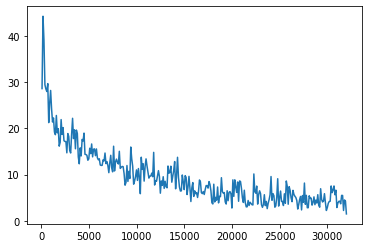

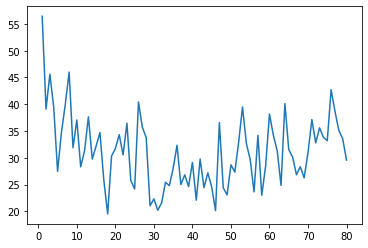

Training - Epoch : 81 (99 / 416)
 loss : 3.487724021077156
Training - Epoch : 81 (199 / 416)
 loss : 4.151146203279495
Training - Epoch : 81 (299 / 416)
 loss : 3.5957127064466476
Training - Epoch : 81 (399 / 416)
 loss : 2.9908304810523987
Validation - Epoch : 81 loss : 30.820243656635284
Training - Epoch : 82 (99 / 416)
 loss : 5.622056350111961
Training - Epoch : 82 (199 / 416)
 loss : 4.592528790235519
Training - Epoch : 82 (299 / 416)
 loss : 3.7966934144496918
Training - Epoch : 82 (399 / 416)
 loss : 2.2332650423049927
Validation - Epoch : 82 loss : 39.09675168991089
Training - Epoch : 83 (99 / 416)
 loss : 5.59250596165657
Training - Epoch : 83 (199 / 416)
 loss : 2.3346443325281143
Training - Epoch : 83 (299 / 416)
 loss : 5.166389673948288
Training - Epoch : 83 (399 / 416)
 loss : 2.9548458606004715
Validation - Epoch : 83 loss : 34.2394460439682
Training - Epoch : 84 (99 / 416)
 loss : 5.237419098615646
Training - Epoch : 84 (199 / 416)
 loss : 3.690403401851654
Training - E

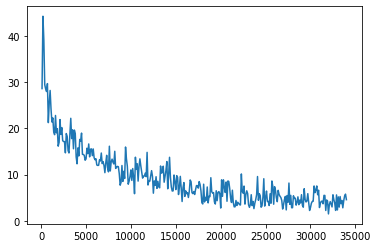

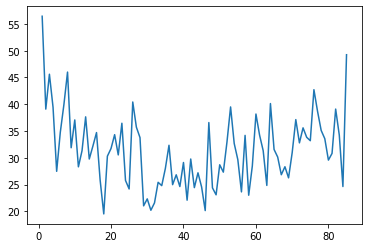

Training - Epoch : 86 (99 / 416)
 loss : 4.683112993836403
Training - Epoch : 86 (199 / 416)
 loss : 4.022794172167778
Training - Epoch : 86 (299 / 416)
 loss : 2.9246422052383423
Training - Epoch : 86 (399 / 416)
 loss : 8.040071696043015
Validation - Epoch : 86 loss : 37.46401086449623
Training - Epoch : 87 (99 / 416)
 loss : 8.462661758065224
Training - Epoch : 87 (199 / 416)
 loss : 6.235680490732193
Training - Epoch : 87 (299 / 416)
 loss : 4.726889401674271
Training - Epoch : 87 (399 / 416)
 loss : 4.678573355078697
Validation - Epoch : 87 loss : 35.076453387737274
Training - Epoch : 88 (99 / 416)
 loss : 4.040547996759415
Training - Epoch : 88 (199 / 416)
 loss : 3.470715716481209
Training - Epoch : 88 (299 / 416)
 loss : 2.7327314019203186
Training - Epoch : 88 (399 / 416)
 loss : 4.576430857181549
Validation - Epoch : 88 loss : 38.041946679353714
Training - Epoch : 89 (99 / 416)
 loss : 3.2287703454494476
Training - Epoch : 89 (199 / 416)
 loss : 3.120854526758194
Training - E

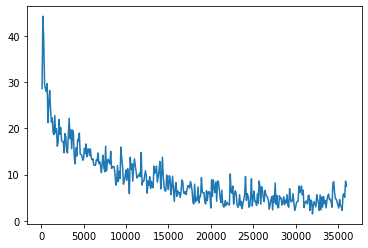

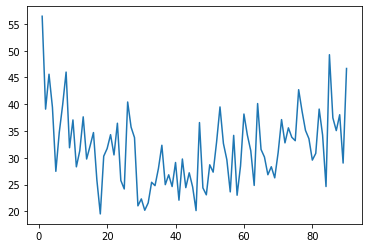

Training - Epoch : 91 (99 / 416)
 loss : 5.406076326966286
Training - Epoch : 91 (199 / 416)
 loss : 3.438100680708885
Training - Epoch : 91 (299 / 416)
 loss : 2.406135931611061
Training - Epoch : 91 (399 / 416)
 loss : 5.259941533207893
Validation - Epoch : 91 loss : 30.478818148374557
Training - Epoch : 92 (99 / 416)
 loss : 2.373985230922699
Training - Epoch : 92 (199 / 416)
 loss : 2.9226366132497787
Training - Epoch : 92 (299 / 416)
 loss : 2.34165221452713
Training - Epoch : 92 (399 / 416)
 loss : 2.0227892696857452
Validation - Epoch : 92 loss : 28.189930379390717
Training - Epoch : 93 (99 / 416)
 loss : 3.2262908667325974
Training - Epoch : 93 (199 / 416)
 loss : 1.6071186661720276
Training - Epoch : 93 (299 / 416)
 loss : 1.5140355378389359
Training - Epoch : 93 (399 / 416)
 loss : 1.4527282416820526
Validation - Epoch : 93 loss : 30.311650335788727
Training - Epoch : 94 (99 / 416)
 loss : 3.507311150431633
Training - Epoch : 94 (199 / 416)
 loss : 4.640662282705307
Training 

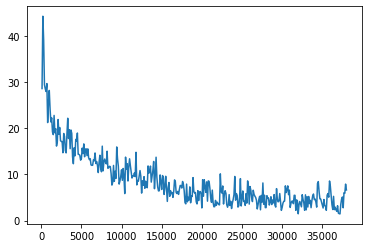

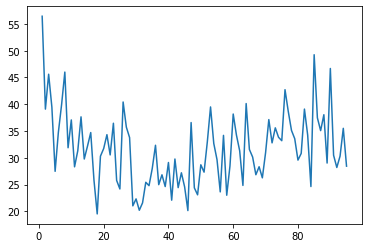

Training - Epoch : 96 (99 / 416)
 loss : 5.321296900510788
Training - Epoch : 96 (199 / 416)
 loss : 6.020143374800682
Training - Epoch : 96 (299 / 416)
 loss : 9.009018748998642
Training - Epoch : 96 (399 / 416)
 loss : 5.897512644529343
Validation - Epoch : 96 loss : 29.028910160064697
Training - Epoch : 97 (99 / 416)
 loss : 2.489573895931244
Training - Epoch : 97 (199 / 416)
 loss : 3.8240024000406265
Training - Epoch : 97 (299 / 416)
 loss : 4.408596992492676
Training - Epoch : 97 (399 / 416)
 loss : 2.9441925436258316
Validation - Epoch : 97 loss : 32.46612870693207
Training - Epoch : 98 (99 / 416)
 loss : 2.191685736179352
Training - Epoch : 98 (199 / 416)
 loss : 4.4506865888834
Training - Epoch : 98 (299 / 416)
 loss : 3.070693925023079
Training - Epoch : 98 (399 / 416)
 loss : 2.6004007160663605
Validation - Epoch : 98 loss : 37.70789906382561
Training - Epoch : 99 (99 / 416)
 loss : 3.3075793236494064
Training - Epoch : 99 (199 / 416)
 loss : 3.2425067871809006
Training - Ep

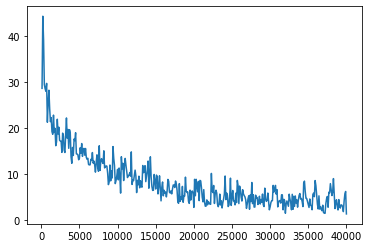

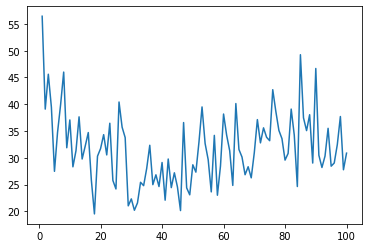

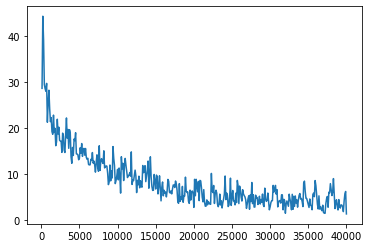

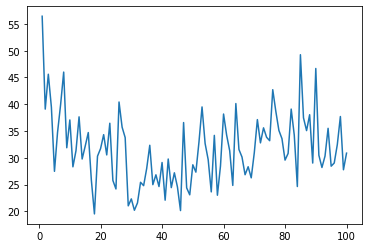

In [ ]:
counter = []
loss_history = [] 
iteration_number= 0
val_counter = []
val_loss_history = []

for epoch in range(1, EPOCH + 1):
    net.train()
    training_loss = 0

    for i, data in enumerate(train_dataloader):
        anchor, positive, negative = data
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
        
        optimizer.zero_grad()
        anchor_output = net(anchor)
        positive_output = net(positive)
        negative_output = net(negative)
        
        loss = criterion(anchor_output, positive_output, negative_output)
        loss.backward()
        optimizer.step()
        
        training_loss += loss.item()
        if (i + 1) % 100 == 0 :
            print(f"Training - Epoch : {epoch} ({i} / {len(train_dataloader)})\n loss : {training_loss}")
            iteration_number +=100
            counter.append(iteration_number)
            loss_history.append(training_loss)
            training_loss = 0
        
        scheduler.step()
    
    net.eval()
    val_loss = 0
    for i, data in enumerate(validation_dataloader):
        anchor, positive, negative = data
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

        anchor_output = net(anchor)
        positive_output = net(positive)
        negative_output = net(negative)

        loss = criterion(anchor_output, positive_output, negative_output)
        val_loss += loss.item()

    print(f"Validation - Epoch : {epoch} loss : {val_loss}")
    val_counter.append(epoch)
    val_loss_history.append(val_loss)
    
    torch.save(net.state_dict(), f"/content/drive/MyDrive/cat_siamese_data/siamese_ver2_{epoch}.pt")

    if epoch % 5 == 0:
        show_plot(counter, loss_history)
        show_plot(val_counter, val_loss_history)

show_plot(counter, loss_history)
show_plot(val_counter, val_loss_history)